In [2]:
from time_lstm import T1TimeLSTM, T2TimeLSTM
from time2vec import T1Time2VecLSTM, T2Time2VecLSTM
from dataset_delay_predictions import Dataset_Delay_Prediction, Dataset_Delay_Prediction_from_list, DatasetDelayPredictionStackOverflow
from time_dependant_representation import TimeDepMasking, TimeDepJointEmbedding
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Masking, Layer, LSTM
import os
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt

In [3]:
#names of the two datasets
dataset_names = [
    'stack-overflow-dataset',
    '2019-10_11_12-dataset_delay_prediction'
]

In [4]:
dataset_name = dataset_names[0] #choose the experiment

In [5]:
# load the dataset
pickle_filename = dataset_name.replace('/', '-')
if os.path.exists(pickle_filename):
    print('Reading pickle file...')
    dataset = pickle.load(open(pickle_filename, 'rb'))

Reading pickle file...


In [6]:
training_set_length = dataset.training_set_length
print(training_set_length)
X_train = dataset.full_features_log_dt[:training_set_length]
seqlen = dataset.full_seqlen[:training_set_length]
y_train = np.array(dataset.full_values[:training_set_length])
print(y_train.shape)

5306
(5306, 1)


In [7]:
test_set_length = len(dataset.full_features_log_dt) - training_set_length
X_test = dataset.full_features_log_dt[training_set_length:]
seqlen_test = dataset.full_seqlen[training_set_length:]
y_test = np.array(dataset.full_values[training_set_length:])
print(y_test.shape)

(1327, 1)


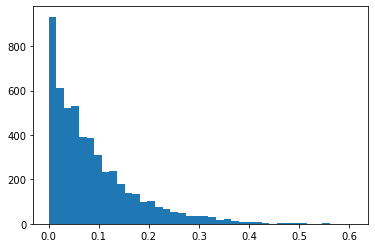

In [8]:
#distribution of target values in train set
plt.hist([y[0] for y in y_train], bins=40)
plt.show()

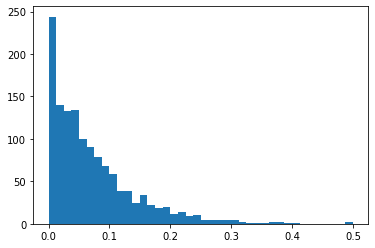

In [9]:
# distribution of target values in test set
plt.hist([y[0] for y in y_test], bins=40)
plt.show()

In [10]:
def Mean_Squarred_Error(np_true_y, np_pred_y):
    return sum([(np_true_y[i][0] - np_pred_y[i][0])**2 for i in range(len(np_true_y))])/len(np_true_y)

In [11]:
padding_value = 0.123456789
padded_inputs = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
print(padded_inputs.shape)

(5306, 735, 24)


In [12]:
lstm_units = 50
activation_fn = 'linear'

number_of_epochs = 10
MSE = {}

In [13]:
#LSTMUni
method = 'LSTMUni'

In [14]:
X_train_uni = [[[feat[-2]] for feat in x] for x in X_train]
padded_inputs_uni = tf.keras.preprocessing.sequence.pad_sequences(X_train_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')

In [15]:
print('size of input tensor: ',)
print(padded_inputs_uni.shape)
regressorLSTMUni = Sequential()
regressorLSTMUni.add(Masking(mask_value=padding_value))
regressorLSTMUni.add(LSTM(units=lstm_units))
regressorLSTMUni.add(Dense(units=y_train.shape[1], activation=activation_fn))
regressorLSTMUni.compile(optimizer='adam', loss='mean_squared_error')
regressorLSTMUni.fit(padded_inputs_uni, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 1)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 104s 20ms/sample - loss: 0.0073
Epoch 2/10
5306/5306 [==============================] - 111s 21ms/sample - loss: 0.0070
Epoch 3/10
5306/5306 [==============================] - 81s 15ms/sample - loss: 0.0070
Epoch 4/10
5306/5306 [==============================] - 75s 14ms/sample - loss: 0.0070
Epoch 5/10
5306/5306 [==============================] - 65s 12ms/sample - loss: 0.0069
Epoch 6/10
5306/5306 [==============================] - 63s 12ms/sample - loss: 0.0069
Epoch 7/10
5306/5306 [==============================] - 64s 12ms/sample - loss: 0.0070
Epoch 8/10
5306/5306 [==============================] - 67s 13ms/sample - loss: 0.0069
Epoch 9/10
5306/5306 [==============================] - 65s 12ms/sample - loss: 0.0069
Epoch 10/10
5306/5306 [==============================] - 58s 

In [16]:
X_test_uni = []
number_of_event = len(X_train[0][0])
for idx in range(test_set_length):
    seq = X_test[idx]
    ts_list = [[a[-2]] for a in seq]
    X_test_uni.append(ts_list)
X_test_uni = [[[seq[-2]] for seq in x] for x in X_test]
padding_value = 0.123456789
padded_inputs_test_uni = tf.keras.preprocessing.sequence.pad_sequences(X_test_uni,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
predLSTMUni = regressorLSTMUni.predict(padded_inputs_test_uni)

In [17]:
MSE[method] = Mean_Squarred_Error(predLSTMUni,y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564}


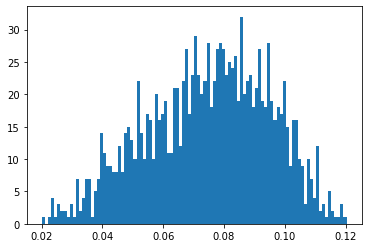

In [18]:
outputs = [pred_[0] for pred_ in predLSTMUni]
plt.hist(outputs, bins=100)
plt.show()

In [19]:
## LSTM Multi

In [20]:
method = 'LSTMMulti'

In [21]:
print('size of input tensor: ',)
print(padded_inputs.shape)
regressorLSTMMulti = Sequential()
regressorLSTMMulti.add(Masking(mask_value=padding_value))
regressorLSTMMulti.add(LSTM(units=lstm_units))
regressorLSTMMulti.add(Dense(units=y_train.shape[1], activation=activation_fn))


regressorLSTMMulti.compile(optimizer='adam', loss='mean_squared_error')
regressorLSTMMulti.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

size of input tensor: 
(5306, 735, 24)
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 73s 14ms/sample - loss: 0.0079
Epoch 2/10
5306/5306 [==============================] - 71s 13ms/sample - loss: 0.0082
Epoch 3/10
5306/5306 [==============================] - 79s 15ms/sample - loss: 0.0087
Epoch 4/10
5306/5306 [==============================] - 88s 17ms/sample - loss: 0.0074
Epoch 5/10
5306/5306 [==============================] - 83s 16ms/sample - loss: 0.0073
Epoch 6/10
5306/5306 [==============================] - 70s 13ms/sample - loss: 0.0074
Epoch 7/10
5306/5306 [==============================] - 5574s 1s/sample - loss: 0.0073
Epoch 8/10
5306/5306 [==============================] - 60s 11ms/sample - loss: 0.0075
Epoch 9/10
5306/5306 [==============================] - 54s 10ms/sample - loss: 0.0073
Epoch 10/10
5306/5306 [==============================] - 56s 10ms/sample - loss: 0.0073


In [22]:
padded_inputs_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                              padding='post',
                                                              value=padding_value,
                                                              dtype='float32')
predLSTMMulti = regressorLSTMMulti.predict(padded_inputs_test)

In [23]:
MSE[method] = Mean_Squarred_Error(predLSTMMulti, y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564, 'LSTMMulti': 0.00502393786527216}


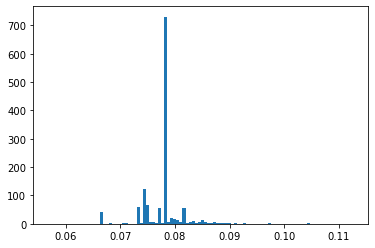

In [24]:
outputs = [pred_[0] for pred_ in predLSTMMulti]
plt.hist(outputs, bins=100)
plt.show()

In [25]:
#T1TimeLSTM
method = 'T1TimeLSTM'

In [26]:
print(padded_inputs.shape)
regressorT1TimeLSTM = Sequential()
regressorT1TimeLSTM.add(Masking(mask_value=padding_value))
regressorT1TimeLSTM.add(T1TimeLSTM(units=lstm_units))
regressorT1TimeLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT1TimeLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT1TimeLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

(5306, 735, 24)
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 94s 18ms/sample - loss: 0.0074
Epoch 2/10
5306/5306 [==============================] - 89s 17ms/sample - loss: 0.0070
Epoch 3/10
5306/5306 [==============================] - 88s 17ms/sample - loss: 0.0069
Epoch 4/10
5306/5306 [==============================] - 87s 16ms/sample - loss: 0.0069
Epoch 5/10
5306/5306 [==============================] - 101s 19ms/sample - loss: 0.0068
Epoch 6/10
5306/5306 [==============================] - 99s 19ms/sample - loss: 0.0067
Epoch 7/10
5306/5306 [==============================] - 87s 16ms/sample - loss: 0.0068
Epoch 8/10
5306/5306 [==============================] - 79s 15ms/sample - loss: 0.0067
Epoch 9/10
5306/5306 [==============================] - 80s 15ms/sample - loss: 0.0067
Epoch 10/10
5306/5306 [==============================] - 79s 15ms/sample - loss: 0.0066


In [27]:
predT1TimeLSTM = regressorT1TimeLSTM.predict(padded_inputs_test)

In [28]:
MSE[method] = Mean_Squarred_Error(predT1TimeLSTM, y_test)

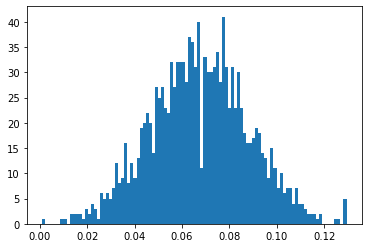

In [29]:
outputs = [pred_[0] for pred_ in predT1TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [30]:
## T2TimeLSTM

In [31]:
method = 'T2TimeLSTM'
print(padded_inputs.shape)
regressorT2TimeLSTM = Sequential()
regressorT2TimeLSTM.add(Masking(mask_value=padding_value))
regressorT2TimeLSTM.add(T2TimeLSTM(units=lstm_units))
regressorT2TimeLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT2TimeLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT2TimeLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)



(5306, 735, 24)
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 123s 23ms/sample - loss: 0.0077
Epoch 2/10
5306/5306 [==============================] - 149s 28ms/sample - loss: 0.0070
Epoch 3/10
5306/5306 [==============================] - 152s 29ms/sample - loss: 0.0069
Epoch 4/10
5306/5306 [==============================] - 154s 29ms/sample - loss: 0.0069
Epoch 5/10
5306/5306 [==============================] - 159s 30ms/sample - loss: 0.0069
Epoch 6/10
5306/5306 [==============================] - 162s 31ms/sample - loss: 0.0068
Epoch 7/10
5306/5306 [==============================] - 157s 30ms/sample - loss: 0.0067
Epoch 8/10
5306/5306 [==============================] - 165s 31ms/sample - loss: 0.0067
Epoch 9/10
5306/5306 [==============================] - 158s 30ms/sample - loss: 0.0066
Epoch 10/10
5306/5306 [==============================] - 161s 30ms/sample - loss: 0.0066


In [32]:
predT2TimeLSTM = regressorT2TimeLSTM.predict(padded_inputs_test)

In [33]:
MSE[method] = Mean_Squarred_Error(predT2TimeLSTM, y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564, 'LSTMMulti': 0.00502393786527216, 'T1TimeLSTM': 0.004804114274942788, 'T2TimeLSTM': 0.0048145870564846845}


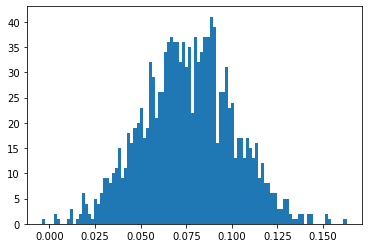

In [34]:
outputs = [pred_[0] for pred_ in predT2TimeLSTM]
plt.hist(outputs, bins=100)
plt.show()

In [35]:
## TimeDepJointEmbedding

In [36]:
method = 'TimeDepJointEmbedding'
print(padded_inputs.shape)
regressorTimeJoint = Sequential()
regressorTimeJoint.add(Masking(mask_value=padding_value))
regressorTimeJoint.add(TimeDepJointEmbedding(units=lstm_units))
regressorTimeJoint.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorTimeJoint.compile(optimizer='adam', loss='mean_squared_error')
history = regressorTimeJoint.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)

(5306, 735, 24)
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 145s 27ms/sample - loss: 0.0075
Epoch 2/10
5306/5306 [==============================] - 140s 26ms/sample - loss: 0.0072
Epoch 3/10
5306/5306 [==============================] - 138s 26ms/sample - loss: 0.0070
Epoch 4/10
5306/5306 [==============================] - 138s 26ms/sample - loss: 0.0069
Epoch 5/10
5306/5306 [==============================] - 138s 26ms/sample - loss: 0.0068
Epoch 6/10
5306/5306 [==============================] - 138s 26ms/sample - loss: 0.0068
Epoch 7/10
5306/5306 [==============================] - 134s 25ms/sample - loss: 0.0068
Epoch 8/10
5306/5306 [==============================] - 134s 25ms/sample - loss: 0.0067
Epoch 9/10
5306/5306 [==============================] - 134s 25ms/sample - loss: 0.0067
Epoch 10/10
5306/5306 [==============================] - 135s 25ms/sample - loss: 0.0067


In [37]:
predTimeJoint = regressorTimeJoint.predict(padded_inputs_test)



In [38]:
MSE[method] = Mean_Squarred_Error(predTimeJoint, y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564, 'LSTMMulti': 0.00502393786527216, 'T1TimeLSTM': 0.004804114274942788, 'T2TimeLSTM': 0.0048145870564846845, 'TimeDepJointEmbedding': 0.004768248550695953}


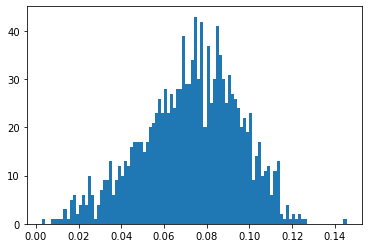

In [39]:
outputs = [pred_[0] for pred_ in predTimeJoint]
plt.hist(outputs, bins=100)
plt.show()

In [40]:
method = 'Naive'
mean_y = sum([y_[0] for y_ in y_train])/len(y_train)
MSE[method] = sum([(y_[0] - mean_y)**2 for y_ in y_test])/len(y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564, 'LSTMMulti': 0.00502393786527216, 'T1TimeLSTM': 0.004804114274942788, 'T2TimeLSTM': 0.0048145870564846845, 'TimeDepJointEmbedding': 0.004768248550695953, 'Naive': 0.005222562369081282}


In [41]:
## Time2Vec

In [42]:
#T1Time2Vec

In [43]:
method = 'T1Time2Vec'
print(padded_inputs.shape)
regressorT1Time2VecLSTM = Sequential()
regressorT1Time2VecLSTM.add(Masking(mask_value=padding_value))
regressorT1Time2VecLSTM.add(T1Time2VecLSTM(units=lstm_units))
regressorT1Time2VecLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT1Time2VecLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT1Time2VecLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)


(5306, 735, 24)
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 141s 27ms/sample - loss: 0.0082
Epoch 2/10
5306/5306 [==============================] - 136s 26ms/sample - loss: 0.0070
Epoch 3/10
5306/5306 [==============================] - 136s 26ms/sample - loss: 0.0069
Epoch 4/10
5306/5306 [==============================] - 135s 25ms/sample - loss: 0.0068
Epoch 5/10
5306/5306 [==============================] - 125s 23ms/sample - loss: 0.0068
Epoch 6/10
5306/5306 [==============================] - 97s 18ms/sample - loss: 0.0068
Epoch 7/10
5306/5306 [==============================] - 97s 18ms/sample - loss: 0.0067
Epoch 8/10
5306/5306 [==============================] - 97s 18ms/sample - loss: 0.0067
Epoch 9/10
5306/5306 [==============================] - 95s 18ms/sample - loss: 0.0069
Epoch 10/10
5306/5306 [==============================] - 94s 18ms/sample - loss: 0.0066


In [44]:
predT1Time2VecLSTM = regressorT1Time2VecLSTM.predict(padded_inputs_test)

In [45]:
MSE[method] = Mean_Squarred_Error(predT1Time2VecLSTM, y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564, 'LSTMMulti': 0.00502393786527216, 'T1TimeLSTM': 0.004804114274942788, 'T2TimeLSTM': 0.0048145870564846845, 'TimeDepJointEmbedding': 0.004768248550695953, 'Naive': 0.005222562369081282, 'T1Time2Vec': 0.0051608544283707645}


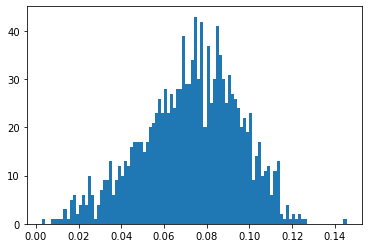

In [46]:
outputs = [pred_[0] for pred_ in predTimeJoint]
plt.hist(outputs, bins=100)
plt.show()

In [47]:
method = 'T2Time2Vec'
print(padded_inputs.shape)
regressorT2Time2VecLSTM = Sequential()
regressorT2Time2VecLSTM.add(Masking(mask_value=padding_value))
regressorT2Time2VecLSTM.add(T2Time2VecLSTM(units=lstm_units))
regressorT2Time2VecLSTM.add(Dense(units=y_train.shape[1], activation=activation_fn))

regressorT2Time2VecLSTM.compile(optimizer='adam', loss='mean_squared_error')
history = regressorT2Time2VecLSTM.fit(padded_inputs, y_train, batch_size=50, epochs=number_of_epochs, verbose=1)



(5306, 735, 24)
Train on 5306 samples
Epoch 1/10
5306/5306 [==============================] - 130s 24ms/sample - loss: 0.0076
Epoch 2/10
5306/5306 [==============================] - 126s 24ms/sample - loss: 0.0070
Epoch 3/10
5306/5306 [==============================] - 123s 23ms/sample - loss: 0.0069
Epoch 4/10
5306/5306 [==============================] - 1987s 374ms/sample - loss: 0.0068
Epoch 5/10
5306/5306 [==============================] - 123s 23ms/sample - loss: 0.0068
Epoch 6/10
5306/5306 [==============================] - 143s 27ms/sample - loss: 0.0068
Epoch 7/10
5306/5306 [==============================] - 187s 35ms/sample - loss: 0.0067
Epoch 8/10
5306/5306 [==============================] - 150s 28ms/sample - loss: 0.0068
Epoch 9/10
5306/5306 [==============================] - 126s 24ms/sample - loss: 0.0067
Epoch 10/10
5306/5306 [==============================] - 146s 28ms/sample - loss: 0.0066


In [48]:
predT2Time2VecLSTM = regressorT2Time2VecLSTM.predict(padded_inputs_test)

In [49]:
MSE[method] = Mean_Squarred_Error(predT2Time2VecLSTM, y_test)
print(MSE)

{'LSTMUni': 0.0046981801064700564, 'LSTMMulti': 0.00502393786527216, 'T1TimeLSTM': 0.004804114274942788, 'T2TimeLSTM': 0.0048145870564846845, 'TimeDepJointEmbedding': 0.004768248550695953, 'Naive': 0.005222562369081282, 'T1Time2Vec': 0.0051608544283707645, 'T2Time2Vec': 0.004852256951291215}


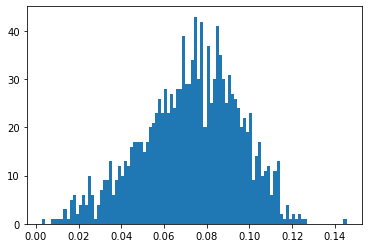

In [50]:
outputs = [pred_[0] for pred_ in predTimeJoint]
plt.hist(outputs, bins=100)
plt.show()

In [70]:
X_test[0].append([padding_value]*24)
x_test = np.array([np.array(X_test[0])])
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                      padding='post',
                                                      value=padding_value,
                                                      dtype='float32')
print(x_test)
print(x_test.shape)

[[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   6.5461355e-03 7.7735703e+04]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   2.6367968e-01 3.5711218e+06]
  ...
  [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
   2.3522446e-02 2.8171734e+05]
  [1.2345679e-01 1.2345679e-01 1.2345679e-01 ... 1.2345679e-01
   1.2345679e-01 1.2345679e-01]
  [1.2345679e-01 1.2345679e-01 1.2345679e-01 ... 1.2345679e-01
   1.2345679e-01 1.2345679e-01]]]
(1, 59, 24)


In [67]:
regressorLSTMMulti(x_test)

<tf.Tensor: id=67740, shape=(1, 1), dtype=float32, numpy=array([[0.07827754]], dtype=float32)>

In [71]:
regressorLSTMMulti(x_test)

<tf.Tensor: id=72352, shape=(1, 1), dtype=float32, numpy=array([[0.07827754]], dtype=float32)>

In [58]:
padded_inputs[0]

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        2.1359603e-01, 2.8184705e+06],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, ..., 0.0000000e+00,
        9.3204759e-02, 1.1562392e+06],
       ...,
       [1.2345679e-01, 1.2345679e-01, 1.2345679e-01, ..., 1.2345679e-01,
        1.2345679e-01, 1.2345679e-01],
       [1.2345679e-01, 1.2345679e-01, 1.2345679e-01, ..., 1.2345679e-01,
        1.2345679e-01, 1.2345679e-01],
       [1.2345679e-01, 1.2345679e-01, 1.2345679e-01, ..., 1.2345679e-01,
        1.2345679e-01, 1.2345679e-01]], dtype=float32)

In [74]:
regressorLSTMMulti(np.array([padded_inputs_test[0]]))

<tf.Tensor: id=110054, shape=(1, 1), dtype=float32, numpy=array([[0.07827754]], dtype=float32)>